In [3]:
import gymnasium as gym
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import imageio
import time

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize, DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

In [25]:
# Numero di ambienti paralleli per il training
NUM_ENVS = 4

# Wrapper personalizzato per applicare la ricompensa modificata
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        torso_angle = self.env.unwrapped.data.qpos[2]

        if not hasattr(self, 'cappottato_start_time'):  # Inizializza al primo step
            self.cappottato_start_time = None

        if torso_angle < -0.7:  # Se è caduto
            if self.cappottato_start_time is None:  # Se è la prima volta che cade
                self.cappottato_start_time = time.time()  # Registra il tempo

            tempo_cappottato = time.time() - self.cappottato_start_time # Calcola da quanto è cappottato

            penalty = 50 * tempo_cappottato  # Penalità cumulativa (10 è un fattore di scala)
            reward -= penalty

        else:  # Se non è più caduto
            self.cappottato_start_time = None  # Resetta il timer

        return obs, reward, terminated, truncated, info

# Funzione per creare un ambiente monitorato con custom reward
def make_env():
    def _init():
        env = gym.make("HalfCheetah-v5",
                        reset_noise_scale=0.013459312664159742,
                        forward_reward_weight=1.4435374113892951,
                        ctrl_cost_weight=0.09129087622076545)
        env = Monitor(env)
        env = CustomRewardWrapper(env)  # Applica il custom reward
        return env
    return _init

# Creazione degli ambienti per il training (con parallelizzazione)
env = SubprocVecEnv([make_env() for _ in range(NUM_ENVS)])
env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)  # Normalizza solo osservazioni

# Selezione automatica del device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Parametri del modello
model_params = {
    "policy": "MlpPolicy",
    "env": env,
    "learning_rate": 0.0006365820963392328,
    "n_steps": 2048,
    "batch_size": 1024,
    "n_epochs": 10,
    "gamma": 0.9932509667338772,
    "gae_lambda": 0.9196254842611007,
    "clip_range": 0.19119739932498195,
    "ent_coef": 0.007152371678457134,
    "verbose": 1,
    "tensorboard_log": "./ppo_HalfCheetah_tensorboard/",
    "device": device,
    "policy_kwargs": dict(net_arch=[256, 256, 128])
}

# Creazione dell'ambiente di valutazione con il custom reward
eval_env = DummyVecEnv([make_env()])
eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10., training=False)

# Callback per valutazione e salvataggi
eval_callback = EvalCallback(eval_env, best_model_save_path="./logs/best_model",
                             log_path="./logs/", eval_freq=5000, deterministic=True, render=False)
checkpoint_callback = CheckpointCallback(save_freq=5000, save_path="./logs/checkpoints/",
                                         name_prefix="ppo_halfcheetah_checkpoint")

# Creazione e training del modello
model = PPO(**model_params)
model.learn(total_timesteps=1_500_000, callback=CallbackList([eval_callback, checkpoint_callback]))

# Salvataggio del modello e normalizzazione
model.save("ppo_HalfCheetah_model")
env.save("vecnormalize_HalfCheetah.pkl")

# Caricamento del modello e della normalizzazione per la valutazione
model = PPO.load("ppo_HalfCheetah_model", device=device)
eval_env = VecNormalize.load("vecnormalize_HalfCheetah.pkl", eval_env)
eval_env.training = False
eval_env.reset()

# Funzione per la valutazione
def evaluate_agent(model, env, episodes=100):
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=episodes, deterministic=True)
    print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    return mean_reward, std_reward

# Valutazione del modello allenato
mean_reward_trained, std_reward_trained = evaluate_agent(model, eval_env, episodes=100)


Using cpu device
Logging to ./ppo_HalfCheetah_tensorboard/PPO_17
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -362     |
| time/              |          |
|    fps             | 9027     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -308         |
| time/                   |              |
|    fps                  | 7214         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0092215715 |
|    clip_fraction        | 0.119        |
|    clip_range           | 0.191        |
|    entropy_loss         | -8.5    

In [26]:
#5. Salviamo il modello
model.save("ppo_HalfCheetah_model")
env.save("vecnormalize_HalfCheetah.pkl")    # salviamo anche i parametri di normalizzazione


Caricando dati da: ./ppo_HalfCheetah_tensorboard/PPO_17


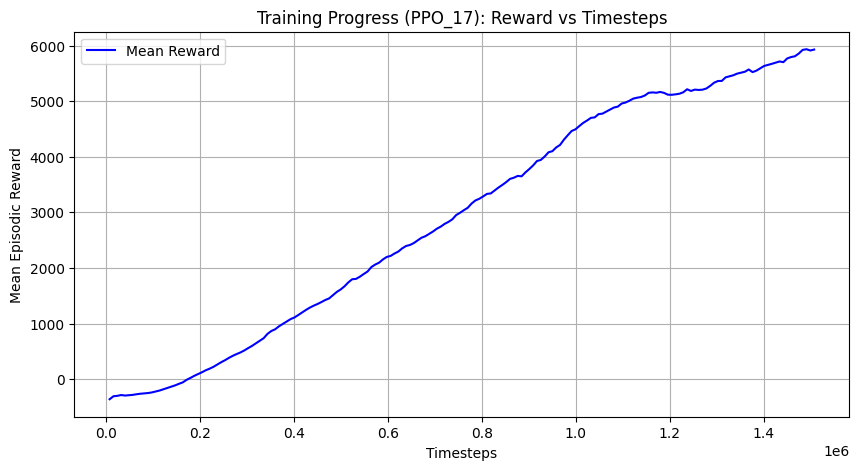

In [8]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Percorso principale del log di TensorBoard
log_dir = "./ppo_HalfCheetah_tensorboard/"

# Specifica manualmente quale cartella usare (cambia il nome se vuoi un'altra versione)
selected_subdir = "PPO_3"  # Cambia con "PPO_1" o "PPO_2" se necessario

# Percorso completo della cartella selezionata
selected_path = os.path.join(log_dir, selected_subdir)

if not os.path.exists(selected_path):
    raise FileNotFoundError(f"La cartella {selected_subdir} non esiste in {log_dir}")

print(f"Caricando dati da: {selected_path}")

# Trova il file degli eventi TensorBoard all'interno della cartella selezionata
event_file = None
for root, dirs, files in os.walk(selected_path):
    for file in files:
        if "events.out.tfevents" in file:
            event_file = os.path.join(root, file)
            break

if event_file is None:
    raise FileNotFoundError(f"Nessun file TensorBoard trovato in {selected_path}")

# Carica i dati da TensorBoard
event_acc = EventAccumulator(event_file)
event_acc.Reload()

# Estrai i timesteps e le rewards medie
timesteps = []
mean_rewards = []

for event in event_acc.Scalars("rollout/ep_rew_mean"):
    timesteps.append(event.step)
    mean_rewards.append(event.value)

# Creazione del grafico
plt.figure(figsize=(10, 5))
plt.plot(timesteps, mean_rewards, label="Mean Reward", color="blue")
plt.xlabel("Timesteps")
plt.ylabel("Mean Episodic Reward")
plt.title(f"Training Progress ({selected_subdir}): Reward vs Timesteps")
plt.legend()
plt.grid(True)
plt.show()

Trained Policy: Mean Reward: 7176.00 ± 92.17
Random Policy: Mean Reward: -313.24 ± 120.58


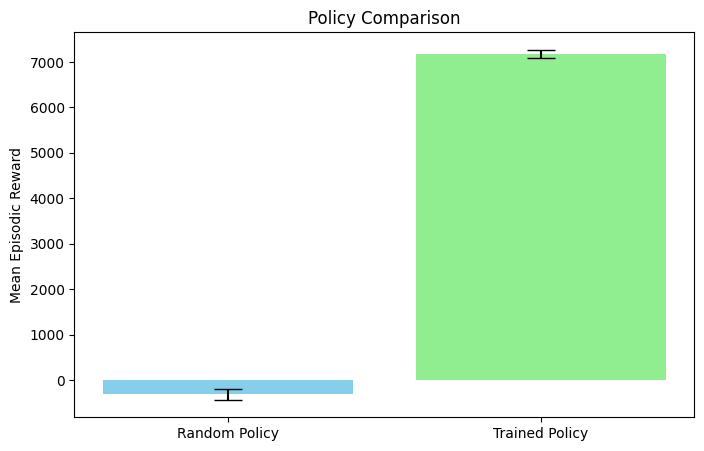

In [11]:
# Percorsi dei file salvati
model_path = "./ppo_HalfCheetah_model.zip"
vecnormalize_path = "./vecnormalize_HalfCheetah.pkl"

# Controlla se i file esistono
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Modello non trovato: {model_path}")
if not os.path.exists(vecnormalize_path):
    raise FileNotFoundError(f"File di normalizzazione non trovato: {vecnormalize_path}")

# Selezione automatica del device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Caricamento del modello addestrato
model = PPO.load(model_path, device=device)

# Wrapper personalizzato per applicare la ricompensa modificata
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        torso_angle = self.env.unwrapped.data.qpos[2]

        if not hasattr(self, 'cappottato_start_time'):  # Inizializza al primo step
            self.cappottato_start_time = None

        if torso_angle < -0.7:  # Se è caduto
            if self.cappottato_start_time is None:  # Se è la prima volta che cade
                self.cappottato_start_time = time.time()  # Registra il tempo

            tempo_cappottato = time.time() - self.cappottato_start_time # Calcola da quanto è cappottato

            penalty = 50 * tempo_cappottato  # Penalità cumulativa (10 è un fattore di scala)
            reward -= penalty

        else:  # Se non è più caduto
            self.cappottato_start_time = None  # Resetta il timer

        return obs, reward, terminated, truncated, info

# Funzione per creare un ambiente monitorato con custom reward
def make_env():
    def _init():
        env = gym.make("HalfCheetah-v5",
                        reset_noise_scale=0.013459312664159742,
                        forward_reward_weight=1.4435374113892951,
                        ctrl_cost_weight=0.09129087622076545)
        env = Monitor(env)
        env = CustomRewardWrapper(env)  # Applica il custom reward
        return env
    return _init

eval_env = DummyVecEnv([make_env()]) 
eval_env = VecNormalize.load(vecnormalize_path, eval_env)  # Carica la normalizzazione
eval_env.training = False  # Disabilita la normalizzazione in fase di test
eval_env.reset()

# Funzione per valutare la policy casuale
def evaluate_random_policy(env, episodes=100):
    """
    Valuta una policy casuale su un ambiente vettorizzato.

    Parametri:
    - env: L'ambiente di simulazione (normalizzato e vettorizzato).
    - episodes: Numero di episodi da eseguire per la valutazione.

    Ritorna:
    - La ricompensa media e la deviazione standard delle ricompense ottenute.
    """
    total_rewards = []
    for _ in range(episodes):
        obs = env.reset()
        done = [False] * env.num_envs
        episode_rewards = np.zeros(env.num_envs)
        while not all(done):
            actions = [env.action_space.sample() for _ in range(env.num_envs)]
            obs, rewards, done, _ = env.step(actions)
            episode_rewards += rewards
        total_rewards.extend(episode_rewards)
    
    mean_reward_random = np.mean(total_rewards)
    std_reward_random = np.std(total_rewards)
    return mean_reward_random, std_reward_random

# Valutazione della policy addestrata
mean_reward_trained, std_reward_trained = evaluate_policy(model, eval_env, n_eval_episodes=100, deterministic=True)

# Valutazione della policy casuale
mean_reward_random, std_reward_random = evaluate_random_policy(eval_env, episodes=100)

# Stampa dei risultati
print(f"Trained Policy: Mean Reward: {mean_reward_trained:.2f} ± {std_reward_trained:.2f}")
print(f"Random Policy: Mean Reward: {mean_reward_random:.2f} ± {std_reward_random:.2f}")

# Creazione del grafico di confronto
labels = ['Random Policy', 'Trained Policy']
means = [mean_reward_random, mean_reward_trained]
stds = [std_reward_random, std_reward_trained]

plt.figure(figsize=(8, 5))
plt.bar(labels, means, yerr=stds, capsize=10, color=['skyblue', 'lightgreen'])
plt.ylabel('Mean Episodic Reward')
plt.title('Policy Comparison')
plt.show()